# Compare to LORA database

# Setup and Info

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from rna_motif_library.plotting import (
    publication_style_ax,
    calculate_subplot_coordinates,
    merge_sequential_coords,
)

In [81]:
def add_motif_type_to_df(df):
    df["motif_1_type"] = df["motif_1_id"].str.split("-").str[0]
    df["motif_2_type"] = df["motif_2_id"].str.split("-").str[0]
    return df

In [91]:
df = pd.read_json("../../lora_compared.json")
df["hbond_num"] = df["hbond_num"].astype(int)
df = add_motif_type_to_df(df)
df = df.query("motif_1_type != 'UNKNOWN' and motif_2_type != 'UNKNOWN'")

In [92]:
df["found_after"].value_counts()

0    3636
1      92
Name: found_after, dtype: int64

In [93]:
df.iloc[0]

lora_index                                    1
motif_1_id           TWOWAY-2-1-GAGG-CAC-1XJR-1
motif_2_id       TWOWAY-4-3-CCGAGG-UACAG-1XJR-1
hbond_score                            1.873443
hbond_num                                     2
are_connected                                 0
in_our_db                                     1
in_their_db                                   1
found_after                                   0
motif_1_type                             TWOWAY
motif_2_type                             TWOWAY
Name: 0, dtype: object

# Plots

## Overlap between LORA and RSIA

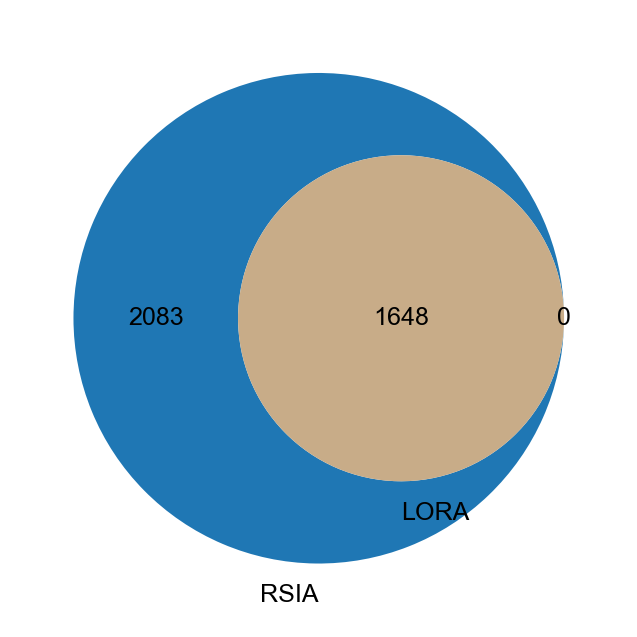

In [85]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

in_our_db = len(df[df["in_our_db"] == True])
in_their_db = len(df[df["in_their_db"] == True])
overlap = len(df[(df["in_our_db"] == True) & (df["in_their_db"] == True)])
colors = sns.color_palette()[:2]  # Get first two colors from default palette
v = venn2(
    subsets=(in_our_db - overlap, in_their_db - overlap, overlap),
    set_labels=("RSIA", "LORA"),
    set_colors=colors,
    alpha=1.0,
)

publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

## Characterizing LORA misses

In [102]:
df_missing = df.query("in_their_db == 0 and in_our_db == 1")
df_missing = df_missing.query("hbond_num > 2")

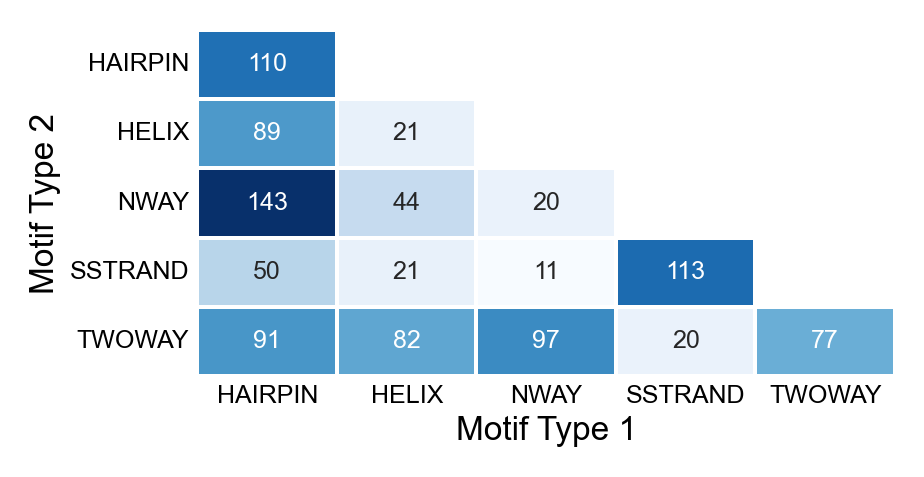

In [103]:
def motif_type_heatmap(df, ax):
    """Create heatmap showing motif type interactions.

    Args:
        df: DataFrame containing motif data with motif_1_type and motif_2_type columns
        ax: matplotlib axes object to plot on

    Returns:
        ax: matplotlib axes object with heatmap
    """
    # Create pivot table of counts
    pivot = pd.crosstab(df["motif_2_type"], df["motif_1_type"])

    # Create heatmap
    ax = sns.heatmap(
        pivot,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
        mask=pivot == 0,  # Hide cells with value 0
        linewidths=0.5,  # Add small space between boxes
        linecolor="white",  # White lines for subtle separation
    )
    # Get current tick labels and modify "Single Strand" to "Single\nStrand"
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    y_labels = [label.get_text() for label in ax.get_yticklabels()]

    # Replace "Single Strand" with "Single\nStrand" in both x and y labels
    x_labels = [label.replace("Single Strand", "Single\nStrand") for label in x_labels]
    y_labels = [label.replace("Single Strand", "Single\nStrand") for label in y_labels]

    # Set the modified labels
    ax.set_yticklabels(y_labels)
    # Customize plot
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)
    ax.set_xlabel("Motif Type 1", labelpad=2)
    ax.set_ylabel("Motif Type 2", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    ax.tick_params(width=0, size=0, pad=2)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(3.0, 1.5), dpi=300)
ax = motif_type_heatmap(df_missing, ax)

In [ ]:
def histogram_num_hbonds(df, ax):
    """Create histogram of number of H-bonds for tertiary contacts.

    Args:
        df: DataFrame containing tertiary contact data
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    ax.hist(df["num_hbonds"], bins=100, edgecolor="black", width=0.5, linewidth=0.5)
    ax.set_xlim(2, 30)
    ax.set_yticks([0, 1000, 2000, 3000, 4000])
    ax.set_yticklabels(["0", "1", "2", "3", "4"])
    ax.set_ylabel("Count (10$^3$)", labelpad=2)
    ax.set_xlabel("Number of H-Bonds", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = figure_2b(df, ax)